In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

# Definicion de constantes y malla

In [2]:
#define las constantes necesarias

#constantes de curvatura 
kc = -0.05 
sk = 0.03
srho = sk
rhoc = 0.01

#constantes del fondo a z=0

OmCDM=0.2589
OmB = 0.0486
OmK = 0.
OmL = 1.-OmB-OmCDM-OmK
H0 = 67.74 #km/(s*Mpc)
c = 299792.458 #km/s

print(OmB)

#constantes del fondo a z=23 (para probar el codigo)

z=100.

#Hini = 4416.9 #km/(s*Mpc)

Hini = np.sqrt(H0**2*((OmCDM+OmB)*(1+z)**3 + OmL)) #km/(s*Mpc)

print(Hini)

OmLin = OmL*(H0/Hini)**2. 
OmM = 1.-OmLin 
OmCDMin = OmM*(OmCDM/(OmB + OmCDM))
OmBin = OmM*(OmB/(OmB + OmCDM))
OmK = 0.

Gyr = 31557600000000000. # en s
Mpc = 3.08567758128*10**(19) # en km
Dt0 = 13.662 * Gyr
Hinis = Hini/Mpc # H inicial en segundos
Dtau0 = Dt0*Hinis # tiempo adimensional

print(Dtau0)

#ecuacion de estado y constantes de velocidad relativa
wb = 0.
wcdm = 0.

sv = 0.025
rv = 0.01
vc = 2.5

l = 60. #*Mpc # escala característica

#a = c/(l*Hini)
a = 1.

L = c/(Hini)

print('l = ', l)
print('OmCDMin = ', OmCDMin)
print('OmBin = ', OmBin)
print('OmLin = ', OmLin)
print('L (Mpc)= ', L)

0.0486
38128.549822851906
532.743292659923
l =  60.0
OmCDMin =  0.8419493791787563
OmBin =  0.15804843502544438
OmLin =  2.185795799326585e-06
L (Mpc)=  7.862676639758348


In [3]:
#define la malla 
n=1000
r0=0.
rn=0.2
h=(rn-r0)/n
r=[]
for i in range(0,n+1):
    b = r0 + i*h
    r.append(b)
#print(r)

# Sistema de ecuaciones y Condiciones Iniciales

In [4]:
def SistEcs3(y,t):
    #y = np.zeros(8*(n+1))
    Th = y[::8]
    Y = y[1::8]
    Ch = y[2::8]
    B = y[3::8]
    sig = y[4::8]
    rho = y[5::8]
    Q = y[6::8]
    rhob = y[7::8]
    
    dydt = np.empty_like(y)
    dThdt = dydt[::8]
    dYdt = dydt[1::8]
    dChdt = dydt[2::8]
    dBdt = dydt[3::8]
    dsigdt = dydt[4::8]
    drhodt = dydt[5::8]
    dQdt = dydt[6::8]
    drhobdt = dydt[7::8]
    
    p = 1./3.*(Q/B)**2./rhob
    PP = -p
    #M = 1./2.*Y*(Y**2.*(sig+Th)**2.-a**2.*Ch**2./B**2.+1.)
    W = np.zeros(n+1)
    
    for i in range(0,n+1):
        if i == 0:
            W[i] = 0.
        else:
            W[i] = -(rho[i]+rhob[i]+OmLin)/2.+1./2.*(sig[i]+Th[i])**2.+a**2./(2.*Y[i]**2.)*(1.-Ch[i]**2./B[i]**2.)-3./2.*PP[i]
    
    dThdt[0] = -1./2.*(rho[0]+rhob[0])+OmLin-Th[0]**2.
    dYdt[0] = 0.
    dChdt[0] = Ch[0]*Th[0]
    dBdt[0] = B[0]*Th[0]
    dsigdt[0] = 0.
    drhodt[0] = -3.*rho[0]*Th[0]
    dQdt[0] = 0.
    drhobdt[0] = -3.*rhob[0]*Th[0]
    
    for i in range(1, n+1):
        dThdt[i] = -1./2.*(rho[i]+rhob[i]+3.*p[i])+OmLin-2.*sig[i]**2.-Th[i]**2.
        dYdt[i] = Y[i]*(Th[i]+sig[i])
        dChdt[i] = -2.*Ch[i]*sig[i]+Ch[i]*Th[i]+(3./(2.*a))*Q[i]*Y[i]
        dBdt[i] = B[i]*(Th[i]-2.*sig[i])
        dsigdt[i] = sig[i]**2.-2.*sig[i]*Th[i]+3./2.*PP[i]-W[i]
        drhodt[i] = -3.*rho[i]*Th[i]
        dQdt[i] = -3.*Th[i]*Q[i]-3.*a*(p[i]-p[i-1])/h+6.*a*PP[i]*Ch[i]/Y[i]
        drhobdt[i] = -3.*(rhob[i]+p[i])*Th[i]-6.*PP[i]*sig[i]-2.*a*Q[i]*Ch[i]/(Y[i]*B[i]**2.)-(a/B[i]**2.)*(Q[i]-Q[i-1])/h+(a*Q[i]/B[i]**3.)*(B[i]-B[i-1])/h
        #drhobdt[i] = -3.*(rhob[i])*Th[i] #solo para LTB
    return dydt
    

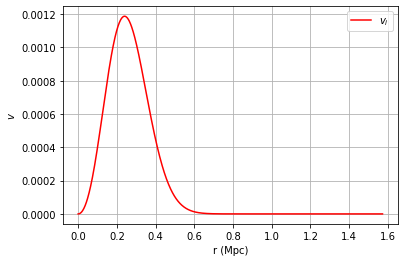

In [5]:
#define las funciones de curvatura, densidad y ricci espacial iniciales

def kini(r):
    Kin = kc*r**2*np.exp(-(r/sk)**2)
    return Kin

def rhoin(r):
    rhoi = OmCDMin - rhoc*np.exp(-(r/srho)**2)
    return rhoi

def R3in(r):
    R3i = np.exp(-(r/sk)**2)*kc/(sk**2)*(-4.*r**2+6.*sk**2)
    return R3i

def Bin(r):
    Bi = 1./np.sqrt(1-kini(r))
    return Bi

def vin(r):
    vi = vc*r**2.*np.exp(-((r-rv)/sv)**2.)
    return vi

def gamin(r):
    gami = 1./(1.-(vin(r)/Bin(r))**2.)
    return gami

def rhobin(r):
    rhobi = gamin(r)*OmBin
    return rhobi

def OmLi(r):
    OmLi = OmLin
    return OmLi


vinvec = np.zeros(n+1)
r2  = np.zeros(n+1)

for i in range(0,n+1):
    vinvec[i] = vin(r[i])
    r2[i] = r[i]*L
    
    
    
#rr = np.linspace(0.0, 1., 1000)
x = vinvec
#x1 = rhoin(rr)
#x2 = R3in(rr)

plt.plot(r2,x,'r',label='$v_i$')

axes = plt.gca()

plt.legend(loc="upper right")
plt.xlabel('r (Mpc)')
plt.ylabel(r'$v$')

plt.grid(True)

#plt.savefig('vinvc2,5.png',bbox_inches='tight')



In [6]:
v0max = np.amax(vinvec)

print('v0max = ', v0max)
v0max2 = v0max*c

print('v0max en km/s = ', v0max2)

L = c/Hini

print('L en Mpc = ', L)

v0max =  0.0011871609136094544
v0max en km/s =  355.901888332504
L en Mpc =  7.862676639758348


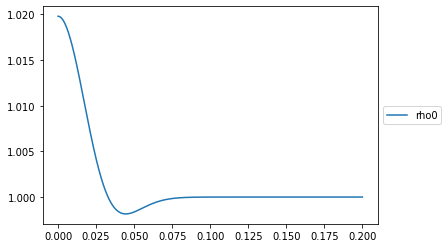

In [7]:
f = np.zeros(8*(n+1)) #de la misma forma que el arreglo de variables, definimos el arreglo de 
                      #condiciones iniciales 
Th0 = f[0::8]
Y0 = f[1::8]
Ch0 = f[2::8]
B0 = f[3::8]
sig0 = f[4::8]
rho0 = f[5::8]
Q0 = f[6::8]
rhob0 = f[7::8]


for i in range(0, n+1):
    Y0[i] = r[i]
    Th0[i] = np.sqrt(rhoin(r[i]) + rhobin(r[i]) + OmLi(r[i]) - 1./6.*R3in(r[i]))
    Ch0[i] = 1.
    B0[i] = Ch0[i]/np.sqrt(1.-kini(r[i]))
    sig0[i] = 0.
    rho0[i] = rhoin(r[i])
    Q0[i] = rhobin(r[i])*vin(r[i])
    rhob0[i] = rhobin(r[i])
    
#W0 = -(rho0+rhob0)/2.+1./2.*Y0**3.*(sig0+Th0)**2.+(a**2.)/2.*(-Ch0**2./B0**2.+1.)*Y0-1./2.*(Q0/B0)**2./rhob0
#W1 = -(rho0+rhob0)/2.+1./2.*(sig0+Th0)**2.+a**2./(2.*Y0**2.)*(1.-Ch0**2./B0**2.)+1./2.*(Q0/B0)**2./rhob0
#M0 = 1./2.*Y0**3.*(sig0+Th0)**2.+a**2.*(-Ch0**2./B0**2.+1.)*Y0


#plt.plot(r,Y0**2,label='Y0^3')
plt.plot(r,Th0,label='rho0')
#plt.plot(r,W0,label='W0')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Resolucion del sistema y presentacion de resultados

In [8]:
#se obtiene la solucion del sistema

tspan = np.linspace(0., Dtau0, 1000)
sol = odeint(SistEcs3, f, tspan)


sol



array([[1.01980390e+00, 0.00000000e+00, 1.00000000e+00, ...,
        8.41949379e-01, 1.29999273e-27, 1.58048435e-01],
       [5.66690294e-01, 0.00000000e+00, 1.49105115e+00, ...,
        2.59885243e-01, 4.01269882e-28, 4.87849471e-02],
       [3.93177162e-01, 0.00000000e+00, 1.91507905e+00, ...,
        1.24564610e-01, 1.92331145e-28, 2.33829280e-02],
       ...,
       [2.08275017e-03, 0.00000000e+00, 1.61500516e+02, ...,
        8.46370984e-07, 1.30681981e-33, 1.58878447e-07],
       [2.08154131e-03, 0.00000000e+00, 1.61679939e+02, ...,
        8.43956129e-07, 1.30309121e-33, 1.58425137e-07],
       [2.08033534e-03, 0.00000000e+00, 1.61859457e+02, ...,
        8.41549243e-07, 1.29937491e-33, 1.57973323e-07]])

In [9]:
#se define una matriz de la longitud del numero de pasos temporales en la integracion por el 
#numero de componentes de la maya

ThSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la expansion Th en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        ThSol[j,0] = sol[j,0] 
        ThSol[j,i] = sol[j,i*8] 


YSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Y en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        YSol[j,0] = sol[j,1] 
        YSol[j,i] = sol[j,(i*8)+1] 

ChSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Ch en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        ChSol[j,0] = sol[j,2] 
        ChSol[j,i] = sol[j,(i*8)+2] 


BSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de B en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        BSol[j,0] = sol[j,3] 
        BSol[j,i] = sol[j,(i*8)+3]  

sigSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion del shear sig en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        sigSol[j,0] = sol[j,4] 
        sigSol[j,i] = sol[j,(i*8)+4]  

QSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion del calor Q en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        QSol[j,0] = sol[j,6] 
        QSol[j,i] = sol[j,(i*8)+6]  
                
rhoSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la densidad de la cdm rho en la maya 
 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        rhoSol[j,0] = sol[j,5] 
        rhoSol[j,i] = sol[j,(i*8)+5]  
        
rhobSol=np.zeros( (len(tspan),n+1) )
        
#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la densidad barionica rhob en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        rhobSol[j,0] = sol[j,7] 
        rhobSol[j,i] = sol[j,(i*8)+7]  
        
#se definen los arreglos de contraste de densidad

deltaSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltaSol[i,:]=rhoSol[i,:]/rhoSol[i,-1]-1
    
deltabSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltabSol[i,:]=rhobSol[i,:]/rhobSol[i,-1]-1
    
# Se define el arreglo de velocidad relativa V

VSol=QSol/rhobSol

rhobstarSol = (1.-VSol**2./BSol**2.)*rhobSol

deltabstarSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltabstarSol[i,:]=rhobstarSol[i,:]/rhobstarSol[i,-1]-1
    

kSol = 1. - (ChSol/BSol)**2.

PPSol = -1./3.*(QSol/BSol)**2./rhobSol
        
#ThSol
#YSol
#ChSol
#BSol
#sigSol
#QSol
#rhoSol
#rhobSol



In [10]:
pnum = 0

if len(tspan) == 1000:
    pnum = 100
elif len(tspan) == 5000:
    pnum = 500
elif len(tspan) == 10000:
    pnum = 1000
    
print(pnum)

100


Text(0, 0.5, 'rho')

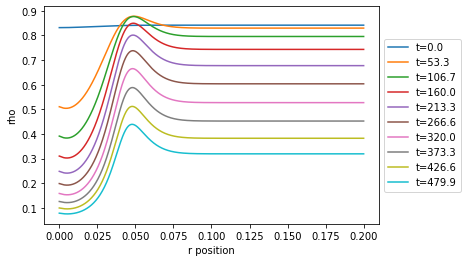

In [11]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, rhoSol[i,:]/ThSol[i,-1]**2, label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('rho')

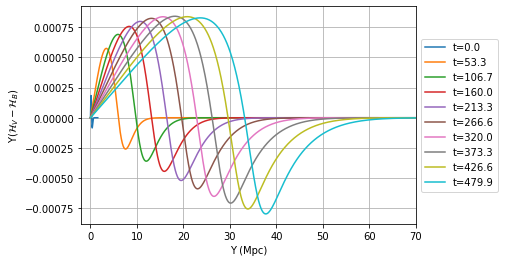

In [12]:
#se realiza una grafica de la soluciones Th vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, YSol[i,:]*(ThSol[i,:]-ThSol[i,-1]), label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
axes.set_xlim([-2,70])
#axes.set_ylim([0.9,1.1])
plt.xlabel(r'Y (Mpc)')
plt.ylabel(r'Y($\mathcal{H}_V-\mathcal{H}_B$)')

axes = plt.gca()


plt.grid(True)


#plt.savefig('YThevvc2,5.png',bbox_inches='tight')

Text(0, 0.5, 'Y')

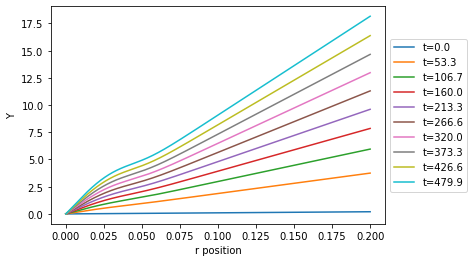

In [13]:
#se realiza una grafica de la soluciones Y vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, YSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Y')

Text(0, 0.5, 'Ch')

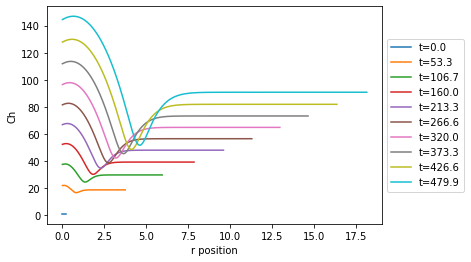

In [14]:
#se realiza una grafica de la soluciones Ch vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], ChSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.013])
plt.xlabel('r position')
plt.ylabel('Ch')

Text(0, 0.5, 'B')

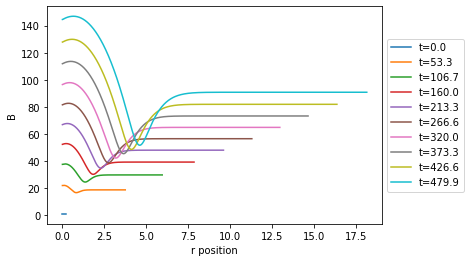

In [15]:
#se realiza una grafica de la soluciones B vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], BSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.2])
plt.xlabel('r position')
plt.ylabel('B')

Text(0, 0.5, 'sig')

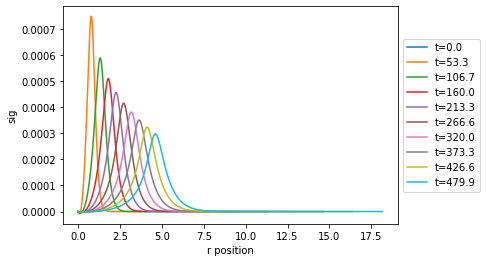

In [16]:
#se realiza una grafica de la soluciones sig vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], sigSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('sig')

Text(0, 0.5, 'Q')

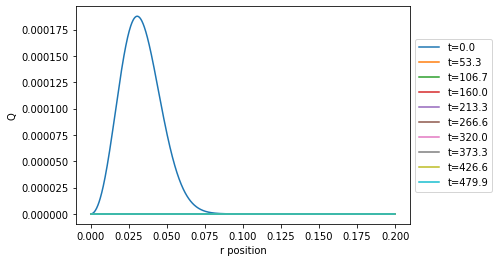

In [17]:
#se realiza una grafica de la soluciones Q vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, QSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Q')

Text(0, 0.5, 'V')

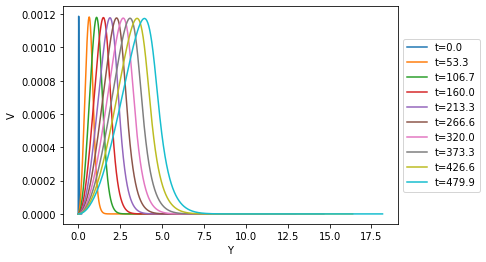

In [18]:
#se realiza una grafica de la soluciones V vs Y para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], VSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.2])
plt.xlabel('Y')
plt.ylabel('V')

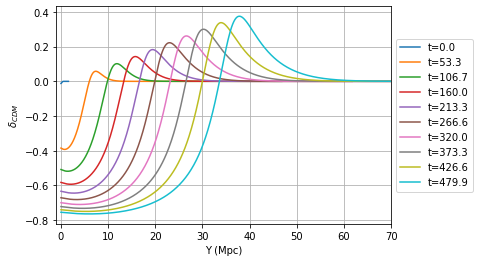

In [19]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, deltaSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
axes.set_xlim([-1,70])
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta_{CDM}$')

axes = plt.gca()


plt.grid(True)


#plt.savefig('deltacdmevvc2,5.png',bbox_inches='tight')

Text(0, 0.5, 'deltab')

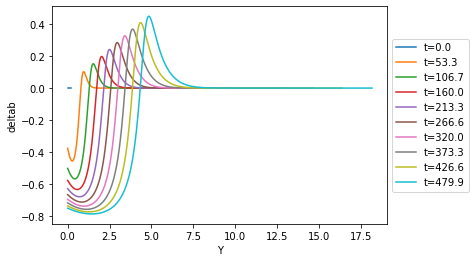

In [20]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], deltabSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y')
plt.ylabel('deltab')

#plt.savefig('deltabar.png')

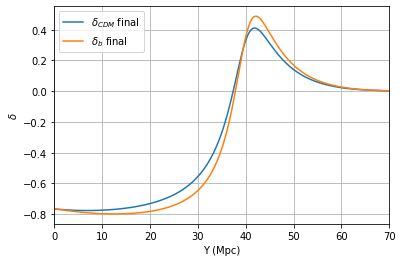

In [21]:
plt.plot(YSol[-1,:]*L, deltaSol[-1,:], label='$\delta_{CDM}$ final')
plt.plot(YSol[-1,:]*L, deltabstarSol[-1,:], label='$\delta_{b}$ final')
plt.legend(loc='upper left')

axes = plt.gca()
axes.set_xlim([0,70])
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta$')

plt.grid(True)


#plt.savefig('deltasfvc2,5.png',bbox_inches='tight')

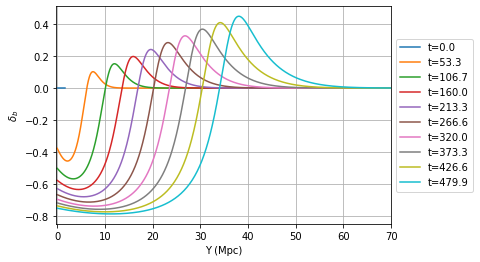

In [22]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion
# para bariones en su propio sistema
for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, deltabstarSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta_b$')



axes = plt.gca()
axes.set_xlim([-0.2,70])

plt.grid(True)


#plt.savefig('deltabevvc2,5.png',bbox_inches='tight')

Text(0, 0.5, 'k')

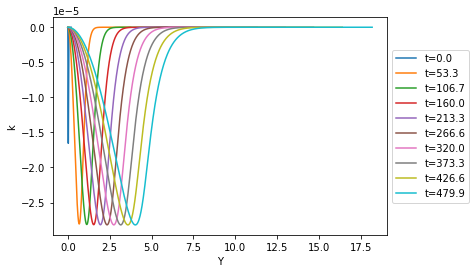

In [23]:
#se realiza una grafica de la soluciones k vs r para cada paso de tiempo de integracion
# para bariones en su propio sistema
for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], kSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y')
plt.ylabel('k')

<ipython-input-24-9090adc2115c>:1: RuntimeWarning: divide by zero encountered in true_divide
  WSol = -(rhoSol+rhobSol)/2.+1./2.*((sigSol+ThSol)**2.+a**2./(YSol**2.)*(-ChSol**2./BSol**2.+1.))+1./2.*(QSol/BSol)**2./rhobSol
<ipython-input-24-9090adc2115c>:1: RuntimeWarning: invalid value encountered in multiply
  WSol = -(rhoSol+rhobSol)/2.+1./2.*((sigSol+ThSol)**2.+a**2./(YSol**2.)*(-ChSol**2./BSol**2.+1.))+1./2.*(QSol/BSol)**2./rhobSol


Text(0, 0.5, 'W')

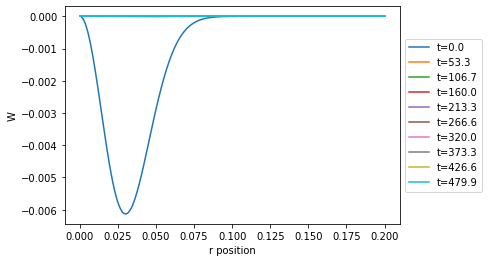

In [24]:
WSol = -(rhoSol+rhobSol)/2.+1./2.*((sigSol+ThSol)**2.+a**2./(YSol**2.)*(-ChSol**2./BSol**2.+1.))+1./2.*(QSol/BSol)**2./rhobSol

for i in range(0, len(tspan), pnum):
    plt.plot(r, WSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('W')

<ipython-input-25-63a5c09cf1a2>:15: RuntimeWarning: divide by zero encountered in double_scalars
  R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
<ipython-input-25-63a5c09cf1a2>:15: RuntimeWarning: invalid value encountered in double_scalars
  R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
<ipython-input-25-63a5c09cf1a2>:29: RuntimeWarning: divide by zero encountered in double_scalars
  R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))
<ipython-input-25-63a5c09cf1a2>:29: RuntimeWarning: invalid value encountered in double_scalars
  R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))


0.0002
[[2.18579580e-06 2.18579580e-06 2.18579580e-06 ... 2.18579580e-06
  2.18579580e-06 2.18579580e-06]
 [           nan 7.50670939e-03 3.76117147e-03 ... 2.19403516e-06
  2.19403516e-06 2.19403516e-06]
 [           nan 4.55341942e-03 2.28393949e-03 ... 2.20836654e-06
  2.20836447e-06 2.20836550e-06]
 ...
 [           nan 2.82542628e-06 2.50638872e-06 ... 2.18588543e-06
  2.18588543e-06 2.18588543e-06]
 [           nan 2.82400749e-06 2.50567723e-06 ... 2.18588526e-06
  2.18588526e-06 2.18588527e-06]
 [           nan 2.82259210e-06 2.50496777e-06 ... 2.18588510e-06
  2.18588510e-06 2.18588511e-06]]


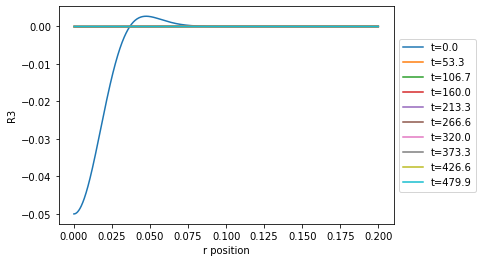

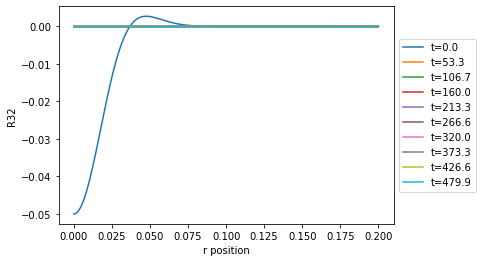

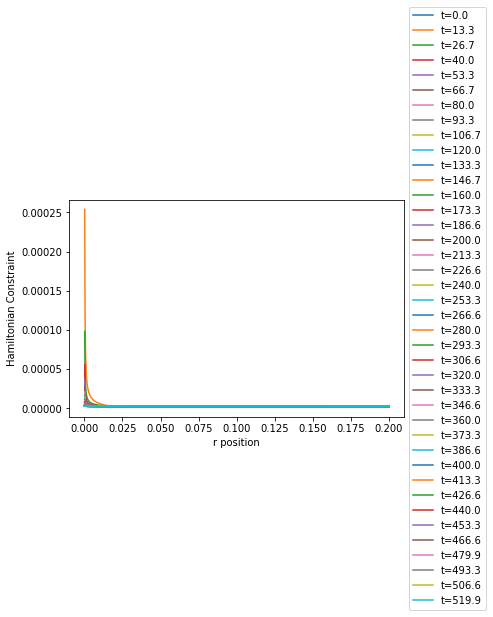

In [25]:
# Checa que se cumplan la constricción hamiltoniana en la solución a cada tiempo 

R30 = np.zeros(n+1)

for j in range(n+1):
    R30[j] = R3in(r[j])

R3Sol = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    for j in range(0, len(tspan), 1):
        if j == 0:
            R3Sol[j,i] = R3in(r[i])/6.
        elif i == 0 and j != 0:
            R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
        else:
            R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i]-BSol[j,i-1])-(1/BSol[j,i]**2.)*(ChSol[j,i]-ChSol[j,i-1])))


            
            
R32Sol = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    for j in range(0, len(tspan), 1):
        if j == 0:
            R32Sol[j,i] = R3in(r[i])/6.
        elif i == 0 and j != 0:
            R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))
        else:
            R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i]-kSol[j,i-1]))

#los R3Sol son en realidad K=R3/6            
            
for i in range(0, len(tspan), 100):
    plt.figure(1)
    plt.plot(r, R3Sol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('R3') 
    
for i in range(0, len(tspan), 100):
    plt.figure(2)
    plt.plot(r, R32Sol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('R32')                         

HamConsRHS = rhoSol + rhobSol - R32Sol + sigSol**2.

HamCheck = ThSol**2. - HamConsRHS

for i in range(0, len(tspan), 25):
    plt.figure(3)
    plt.plot(r, HamCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Hamiltonian Constraint')                         



print(h)
print(HamCheck)

<ipython-input-26-93cc55b67574>:7: RuntimeWarning: invalid value encountered in true_divide
  ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i]-((sigSol[:,i+1]-sigSol[:,i])/h)-(ThSol[:,i+1]-ThSol[:,i])/h


[[            nan  7.98968495e-03  2.39660519e-02 ...  2.47629571e-27
   2.19758446e-27  1.94998910e-27]
 [            nan -1.77251690e-02 -3.49816860e-03 ... -1.58687427e-08
  -1.58489314e-08 -1.58367987e-08]
 [            nan -3.25388760e-02 -1.42616387e-02 ...  4.64651690e-08
   4.64186868e-08  4.63714166e-08]
 ...
 [            nan -1.57631739e-03 -8.14144428e-04 ...  1.91904838e-07
   1.91710196e-07  1.91527643e-07]
 [            nan -1.57363286e-03 -8.12758586e-04 ...  1.91716122e-07
   1.91521671e-07  1.91339299e-07]
 [            nan -1.57095372e-03 -8.11375564e-04 ...  1.91527523e-07
   1.91333263e-07  1.91151071e-07]]


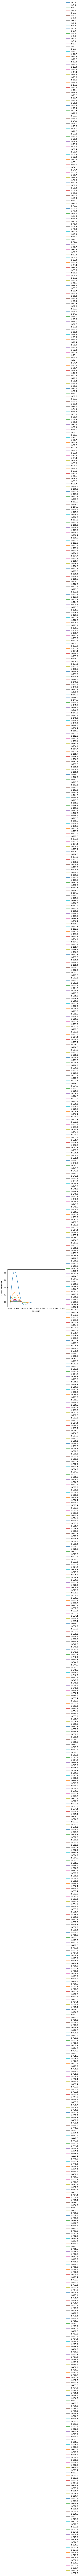

In [26]:
# Checa que se cumplan la constricción del shear en la solución a cada tiempo 

ShearCheck = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    if i == 0:
        ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i]-((sigSol[:,i+1]-sigSol[:,i])/h)-(ThSol[:,i+1]-ThSol[:,i])/h
    else:
        ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i]-((sigSol[:,i]-sigSol[:,i-1])/h)-(ThSol[:,i]-ThSol[:,i-1])/h

for i in range(0, len(tspan), 1):
    plt.figure(3)
    plt.plot(r, ShearCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Shear Constraint')

print(ShearCheck)

<ipython-input-27-2ae45ede954f>:7: RuntimeWarning: invalid value encountered in true_divide
  WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i+1]-PPSol[:,i])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i+1]+rhobSol[:,i+1]-rhoSol[:,i]-rhobSol[:,i])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i+1]-WSol[:,i])/h)


[[            nan             nan  7.26877672e-03 ... -5.47544040e-06
  -5.46995948e-06 -5.46448952e-06]
 [            nan             nan  8.75243144e-03 ... -5.49901455e-06
  -5.49351567e-06 -5.48802082e-06]
 [            nan             nan  5.29234258e-03 ... -5.52602149e-06
  -5.52048737e-06 -5.51496827e-06]
 ...
 [            nan             nan -2.73385367e-03 ... -5.47573427e-06
  -5.47025305e-06 -5.46478280e-06]
 [            nan             nan -2.73385473e-03 ... -5.47573413e-06
  -5.47025292e-06 -5.46478267e-06]
 [            nan             nan -2.73385604e-03 ... -5.47573400e-06
  -5.47025278e-06 -5.46478254e-06]]


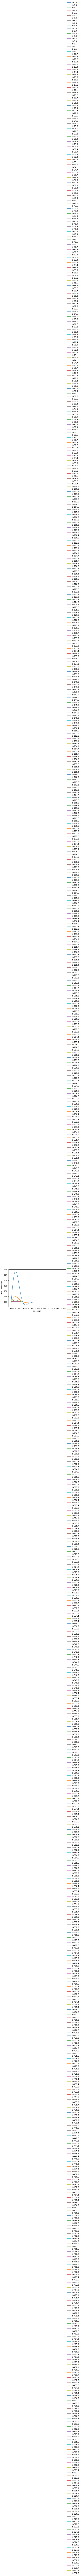

In [27]:
# Checa que se cumplan la constricción del W en la solución a cada tiempo 

WCheck = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    if i == 0:
        WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i+1]-PPSol[:,i])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i+1]+rhobSol[:,i+1]-rhoSol[:,i]-rhobSol[:,i])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i+1]-WSol[:,i])/h)
    else:
        WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i]-PPSol[:,i-1])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i]+rhobSol[:,i]-rhoSol[:,i-1]-rhobSol[:,i-1])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i]-WSol[:,i-1])/h)

for i in range(0, len(tspan), 1):
    plt.plot(r, WCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Weyl Constraint')
        
print(WCheck)

# Deltas promedio

[-7.25293810e-19  6.79069020e-05  1.42528926e-04  2.06934543e-04
  2.65506628e-04  3.20260821e-04  3.72501517e-04  4.22655976e-04
  4.71109938e-04  5.18127418e-04  5.63900686e-04  6.08987644e-04
  6.52730362e-04  6.95586725e-04  7.37634523e-04  7.78939455e-04
  8.19557796e-04  8.59538182e-04  8.98923529e-04  9.37751528e-04
  9.76055754e-04  1.01386626e-03  1.05121008e-03  1.08811165e-03
  1.12459332e-03  1.16067539e-03  1.19718958e-03  1.23256342e-03
  1.26758918e-03  1.30228105e-03  1.33665253e-03  1.37071646e-03
  1.40448444e-03  1.43796747e-03  1.47117581e-03  1.50411912e-03
  1.53680644e-03  1.56924633e-03  1.60144684e-03  1.63341554e-03
  1.66515961e-03  1.69668584e-03  1.72800065e-03  1.75911016e-03
  1.79002020e-03  1.82073627e-03  1.85126364e-03  1.88160731e-03
  1.91177206e-03  1.94176177e-03  1.97158111e-03  2.00123473e-03
  2.03072660e-03  2.06006213e-03  2.08924319e-03  2.11827322e-03
  2.14715565e-03  2.17589558e-03  2.20449127e-03  2.23295006e-03
  2.26127346e-03  2.28946

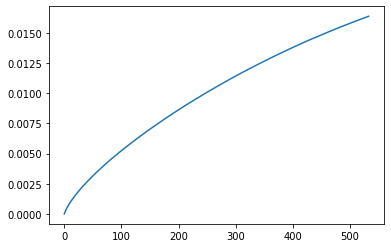

In [28]:
#Busca los cruces con el eje x de la función delta final (para CDM)identificando 
#cambios de signo para cada tiempo

zero_crossings = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zero_crossings[i] = np.where(np.diff(np.sign(deltaSol[i,:])))[0][0]

zc = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zc[i] = int(zero_crossings[i]) 
    
#Define un arreglo anulando todos los valores de delta1 antes del valor de cruce

delta1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        delta1[j,i] = deltaSol[j,i] 
    
Y1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        Y1[j,i] = YSol[j,i] 
        
B1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        B1[j,i] = BSol[j,i] 
        
#realiza la integral de los ejes r

promd1 = np.zeros(len(tspan))
vol1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promd1[j] = np.trapz(delta1[j,:]*Y1[j,:]*B1[j,:],x = r)
    vol1[j] = np.trapz(Y1[j,:]*B1[j,:],x = r)

deltaprom1 = promd1/vol1

plt.plot(tspan, deltaprom1)

print(deltaprom1)

[5.33568868e-08 6.15649979e-04 9.62025430e-04 1.20459055e-03
 1.39455909e-03 1.55099716e-03 1.68556204e-03 1.80448530e-03
 1.91167474e-03 2.00973608e-03 2.10049073e-03 2.18526143e-03
 2.26503724e-03 2.34057776e-03 2.41247870e-03 2.48121584e-03
 2.54717521e-03 2.61067402e-03 2.67197716e-03 2.73130717e-03
 2.78885324e-03 2.84477755e-03 2.89922016e-03 2.95230287e-03
 3.00413260e-03 3.05480333e-03 3.10439837e-03 3.15299202e-03
 3.20065102e-03 3.24743419e-03 3.29339510e-03 3.33858275e-03
 3.38304096e-03 3.42680998e-03 3.46992653e-03 3.51242429e-03
 3.55433416e-03 3.59568472e-03 3.63650227e-03 3.67681118e-03
 3.71663403e-03 3.75599182e-03 3.79490409e-03 3.83338910e-03
 3.87146391e-03 3.90914448e-03 3.94644576e-03 3.98338181e-03
 4.01996582e-03 4.05620930e-03 4.08921771e-03 4.12482545e-03
 4.16012761e-03 4.19513616e-03 4.22985807e-03 4.26430209e-03
 4.29847671e-03 4.33239236e-03 4.36605030e-03 4.39946347e-03
 4.43263694e-03 4.46557768e-03 4.49829200e-03 4.53078649e-03
 4.56306759e-03 4.595139

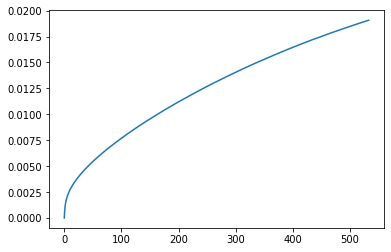

In [29]:
#realiza lo mismo que la celda anterior pero para bariones

zero_crossingsb = np.zeros(len(tspan))

for i in range(1,len(tspan)):
    zero_crossingsb[i] = np.where(np.diff(np.sign(deltabSol[i,:])))[0][0]

zcb = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zcb[i] = int(zero_crossingsb[i]) 

deltab1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        deltab1[j,i] = deltabSol[j,i] 
    
Yb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        Yb1[j,i] = YSol[j,i] 
        
Bb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        Bb1[j,i] = BSol[j,i] 

promdb1 = np.zeros(len(tspan))
volb1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdb1[j] = np.trapz(deltab1[j,:]*Yb1[j,:]*Bb1[j,:],x = r)
    volb1[j] = np.trapz(Yb1[j,:]*Bb1[j,:],x = r)

deltapromb1 = promdb1/volb1

plt.plot(tspan, deltapromb1)

print(deltapromb1)

[9.51950864e-18 6.15642649e-04 9.62020947e-04 1.20458736e-03
 1.39455671e-03 1.55099526e-03 1.68556046e-03 1.80448396e-03
 1.91167359e-03 2.00973506e-03 2.10048983e-03 2.18526062e-03
 2.26503651e-03 2.34057709e-03 2.41247808e-03 2.48121527e-03
 2.54717469e-03 2.61067353e-03 2.67197671e-03 2.73130674e-03
 2.78885283e-03 2.84477717e-03 2.89921980e-03 2.95230253e-03
 3.00413228e-03 3.05480302e-03 3.10439807e-03 3.15299174e-03
 3.20065076e-03 3.24743393e-03 3.29339485e-03 3.33858251e-03
 3.38304073e-03 3.42680976e-03 3.46992631e-03 3.51242408e-03
 3.55433396e-03 3.59568452e-03 3.63650209e-03 3.67681100e-03
 3.71663386e-03 3.75599165e-03 3.79490393e-03 3.83338894e-03
 3.87146375e-03 3.90914433e-03 3.94644561e-03 3.98338167e-03
 4.01996568e-03 4.05620916e-03 4.08921757e-03 4.12482532e-03
 4.16012748e-03 4.19513604e-03 4.22985794e-03 4.26430196e-03
 4.29847659e-03 4.33239224e-03 4.36605019e-03 4.39946336e-03
 4.43263683e-03 4.46557757e-03 4.49829189e-03 4.53078638e-03
 4.56306748e-03 4.595139

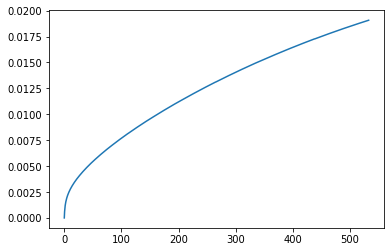

In [30]:
#realiza el calculo anterior para deltarhob en su sistema de referencia

zero_crossingsbstar = np.zeros(len(tspan))

for i in range(1,len(tspan)):
    zero_crossingsbstar[i] = np.where(np.diff(np.sign(deltabstarSol[i,:])))[0][0]

zcbs = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zcbs[i] = int(zero_crossingsbstar[i]) 

deltabstar1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zcbs[j]),n+1):
        deltabstar1[j,i] = deltabstarSol[j,i] 
    
Ybstar1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcbs[j]),n+1):
        Ybstar1[j,i] = YSol[j,i] 
        
Bbstar1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcbs[j]),n+1):
        Bbstar1[j,i] = BSol[j,i] 

promdbs1 = np.zeros(len(tspan))
volbs1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdbs1[j] = np.trapz(deltabstar1[j,:]*Ybstar1[j,:]*Bbstar1[j,:],x = r)
    volbs1[j] = np.trapz(Ybstar1[j,:]*Bbstar1[j,:],x = r)

deltaprombs1 = promdbs1/volbs1

plt.plot(tspan, deltaprombs1)

print(deltaprombs1)

In [31]:
#Calcula el redshift z de cada tiempo dado el factor métrico asintótico (r->infinito) B

z1= np.zeros(len(tspan))

for i in range(len(tspan)):
    z1[i] = BSol[0,-1]/BSol[i,-1]*(1+z)-1
    

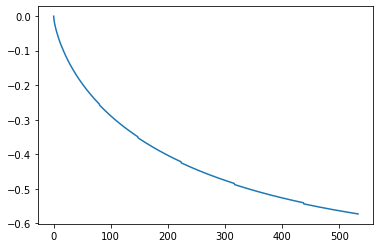

In [32]:
#realiza el mismo cálculo de las deltas pero para la infradensidad de CDM


deltaV1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        deltaV1[j,i] = deltaSol[j,i] 
    
YV1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        YV1[j,i] = YSol[j,i] 
        
BV1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        BV1[j,i] = BSol[j,i] 

promdV1 = np.zeros(len(tspan))
volV1 = np.zeros(len(tspan))


for j in range(len(tspan)):
    promdV1[j] = np.trapz(deltaV1[j,:]*YV1[j,:]*BV1[j,:],x = r)
    volV1[j] = np.trapz(YV1[j,:]*BV1[j,:],x = r)

deltapromV1 = promdV1/volV1

plt.plot(tspan, deltapromV1)

#print(deltapromV1)

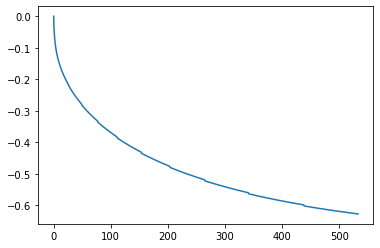

In [33]:
#realiza el mismo cálculo de las deltas pero para la infradensidad 


zcb = np.zeros(len(tspan))

for i in range(1,len(tspan)):
    zcb[i] = int(zero_crossingsb[i]) 

deltaVb1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        deltaVb1[j,i] = deltabSol[j,i] 
    
YVb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        YVb1[j,i] = YSol[j,i] 
        
BVb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        BVb1[j,i] = BSol[j,i] 

promdVb1 = np.zeros(len(tspan))
volVb1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdVb1[j] = np.trapz(deltaVb1[j,:]*YVb1[j,:]*BVb1[j,:],x = r)
    volVb1[j] = np.trapz(YVb1[j,:]*BVb1[j,:],x = r)

deltapromVb1 = np.zeros(len(tspan))    
    
for i in range(len(tspan)):
    if i == 0:
        deltapromVb1[i] = 0
    else:
        deltapromVb1[i] = promdVb1[i]/volVb1[i]
        

plt.plot(tspan, deltapromVb1)

#print(deltapromVb1)

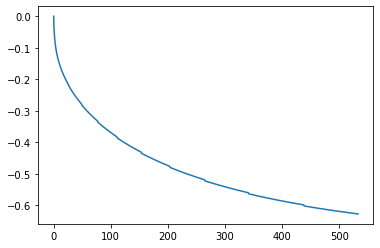

In [34]:
#realiza el mismo cálculo de las deltas pero para la infradensidad de bariones en su 
#sistema preferencial


deltaVbs1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zcbs[j])):
        deltaVbs1[j,i] = deltabstarSol[j,i] 
    
YVbs1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcbs[j])):
        YVbs1[j,i] = YSol[j,i] 
        
BVbs1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcbs[j])):
        BVbs1[j,i] = BSol[j,i] 

promdVbs1 = np.zeros(len(tspan))
volVbs1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdVbs1[j] = np.trapz(deltaVbs1[j,:]*YVbs1[j,:]*BVbs1[j,:],x = r)
    volVbs1[j] = np.trapz(YVbs1[j,:]*BVbs1[j,:],x = r)

deltapromVbs1 = np.zeros(len(tspan))    
    
for i in range(len(tspan)):
    if i == 0:
        deltapromVbs1[i] = 0
    else:
        deltapromVbs1[i] = promdVbs1[i]/volVbs1[i]
        

plt.plot(tspan, deltapromVbs1)

#print(deltapromVbs1)

# Funciones de crecimiento f

<ipython-input-35-0cb15c626a0a>:3: RuntimeWarning: invalid value encountered in log
  logdeltaS = np.log(deltaprom1)
<ipython-input-35-0cb15c626a0a>:6: RuntimeWarning: divide by zero encountered in log
  logdeltabVS = np.log(abs(deltapromVb1))


Text(0, 0.5, 'f')

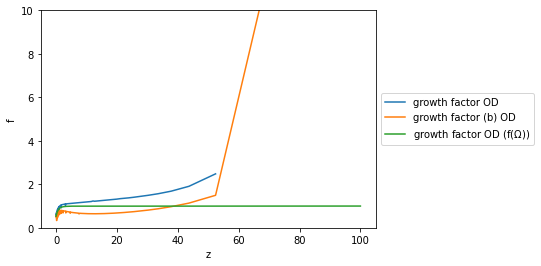

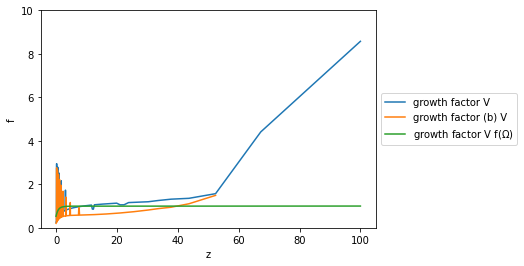

In [35]:
#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para la sobredensidad

logdeltaS = np.log(deltaprom1)
logdeltabS = np.log(deltapromb1)
logdeltaVS = np.log(abs(deltapromV1))
logdeltabVS = np.log(abs(deltapromVb1))

loga = np.log(BSol[:,-1])


#gf = np.diff(logdelta) / np.diff(loga)
#gfb = np.diff(logdeltab) / np.diff(loga)  

gfS = np.gradient(logdeltaS, loga)
gfbS = np.gradient(logdeltabS, loga)
gfVS = np.gradient(logdeltaVS, loga)
gfbVS = np.gradient(logdeltabVS, loga)

fOm = ((rhoSol[:,-1]+rhobSol[:,-1])/ThSol[:,-1]**2.)**(6./11.)



#no se si sirve de algo pero también los grafica

plt.figure(1)

plt.plot(z1,gfS,label='growth factor OD')
plt.plot(z1,gfbS,label='growth factor (b) OD')
plt.plot(z1,fOm,label='growth factor OD (f($\Omega$))')

axes = plt.gca()
#axes.set_xlim([0,18])
axes.set_ylim([0,10])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')

#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para el void

plt.figure(2)

plt.plot(z1,gfVS,label='growth factor V')
plt.plot(z1,gfbVS,label='growth factor (b) V')
plt.plot(z1,fOm,label='growth factor V f($\Omega$)')

axes = plt.gca()
#axes.set_xlim([0,18])
axes.set_ylim([0,10])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')




#print(fOm)

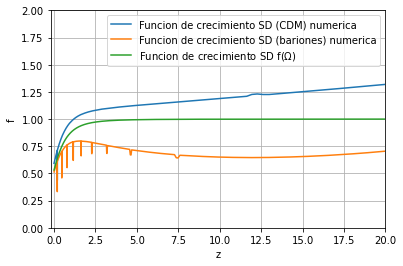

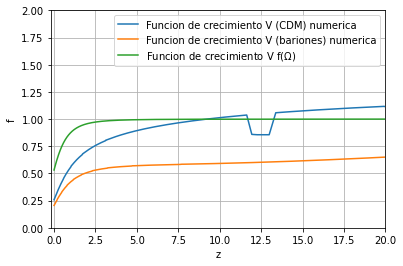

In [36]:
#Intento de eliminar los puntos feos de las gráficas anteriores

gfSC = np.zeros(len(tspan))
gfbSC = np.zeros(len(tspan))
gfVSC = np.zeros(len(tspan))
gfbVSC = np.zeros(len(tspan))

#discrimina los valores feos de los datos con un criterio de comparación con datos adyacentes, como los datos 
#feos vienen en pares, se realiza este criterio dos veces para OD y dos para voids la primer correción es 
# gfSC y la segunda gfSCC (ya me acordé S es por ser la suma de deltaprom1 + deltapromb1)

for i in range(0,len(tspan)):
    if i == 0:
        gfSC[i] = gfS[i]
    elif i > 0 and i < len(tspan)-1:
        uwuS1 = abs(gfS[i+1]/gfS[i])
        #print(uwu)
        if uwuS1 > 1:
            gfSC[i] = gfS[i-1]
        else:
            gfSC[i] = gfS[i]
    else:
        gfSC[i] = gfS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbSC[i] = gfbS[i]
    elif i > 0 and i < len(tspan)-1:
        uwubS1 = abs(gfbS[i+1]/gfbS[i])
        #print(uwu)
        if uwuS1 < 1:
            gfbSC[i] = gfbS[i-1]
        else:
            gfbSC[i] = gfbS[i]
    else:
        gfbSC[i] = gfbS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfVSC[i] = gfVS[i]
    elif i > 0 and i < len(tspan)-1:
        uwuS2 = abs(gfVS[i+1]/gfVS[i])
        #print(uwu)
        if uwuS2 < 1:
            gfVSC[i] = gfVS[i+1]
        else:
            gfVSC[i] = gfVS[i]
    else:
        gfVSC[i] = gfVS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbVSC[i] = gfbVS[i]
    elif i > 0 and i < len(tspan)-1:
        uwubS2 = abs(gfbVS[i+1]/gfbVS[i])
        #print(uwu)
        if uwubS2 < 1:
            gfbVSC[i] = gfbVS[i+1]
        else:
            gfbVSC[i] = gfbVS[i]
    else:
        gfbVSC[i] = gfbVS[i]
        
gfSCC = np.zeros(len(tspan))
gfbSCC = np.zeros(len(tspan))
gfVSCC = np.zeros(len(tspan))
gfbVSCC = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    if i == 0:
        gfSCC[i] = gfSC[i]
    elif i > 0 and i < len(tspan)-1:
        owoS2 = abs(gfSC[i+1]/gfSC[i])
        #print(owo)
        if owoS2 > 1:
            gfSCC[i] = gfSC[i-1]
        else:
            gfSCC[i] = gfSC[i]
    else:
        gfSCC[i] = gfSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbSCC[i] = gfbSC[i]
    elif i > 0 and i < len(tspan)-1:
        owobS2 = abs(gfbSC[i+1]/gfbSC[i])
        #print(owo)
        if owobS2 < 1:
            gfbSCC[i] = gfbSC[i-1]
        else:
            gfbSCC[i] = gfbSC[i]
    else:
        gfbSCC[i] = gfbSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfVSCC[i] = gfVSC[i]
    elif i > 0 and i < len(tspan)-1:
        owoS1 = abs(gfVSC[i+1]/gfVSC[i])
        #print(owo)
        if owoS1 < 1:
            gfVSCC[i] = gfVSC[i+1]
        else:
            gfVSCC[i] = gfVSC[i]
    else:
        gfVSCC[i] = gfVSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbVSCC[i] = gfbVSC[i]
    elif i > 0 and i < len(tspan)-1:
        owobS1 = abs(gfbVSC[i+1]/gfbVSC[i])
        #print(owo)
        if owobS1 < 1:
            gfbVSCC[i] = gfbVSC[i+1]
        else:
            gfbVSCC[i] = gfbVSC[i]
    else:
        gfbVSCC[i] = gfbVSC[i]
        

plt.figure(1)

plt.plot(z1,gfSCC,label='Funcion de crecimiento SD (CDM) numerica')
plt.plot(z1,gfbSCC,label='Funcion de crecimiento SD (bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento SD f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOmvc2,5.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,gfVSCC,label='Funcion de crecimiento V (CDM) numerica')
plt.plot(z1,gfbVSCC,label='Funcion de crecimiento V (bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento V f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOmVvc2,5.png',bbox_inches='tight')

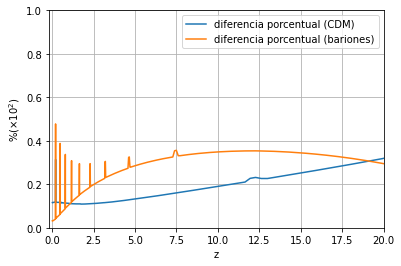

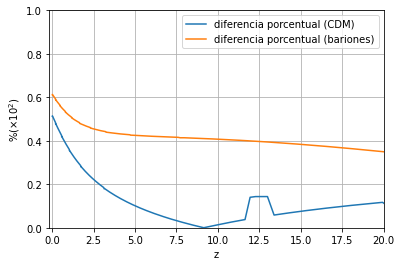

In [37]:
#calcula la diferencia porcentual entre el factor de crecimiento de f(omega) y los datos numéricos

fOmpercent = abs(gfSCC/fOm-1.)
fOmpercentb = abs(gfbSCC/fOm-1.)
fOmpercentV = abs(gfVSCC/fOm-1.)
fOmpercentbV = abs(gfbVSCC/fOm-1.)

plt.figure(1)

plt.plot(z1,fOmpercent,label='diferencia porcentual (CDM)')
plt.plot(z1,fOmpercentb,label='diferencia porcentual (bariones)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfvc2,5.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,fOmpercentV,label='diferencia porcentual (CDM)')
plt.plot(z1,fOmpercentbV,label='diferencia porcentual (bariones)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfVvc2,5.png',bbox_inches='tight')


In [38]:
z20=np.where(np.logical_and(z1>=19, z1<=22))
z10=np.where(np.logical_and(z1>=10, z1<=11))


difzb20 = np.zeros(len(tspan))

for i in range(11,len(tspan)):
    difzb20[i] = fOmpercentb[i]

difmaxb=np.amax(difzb20)
zdifmaxb=np.where(difzb20 == difmaxb)

print(z20)
print(z10)
print(z1[33])
print('diferencia porcentual maxima: ',difmaxb)
print('este z donde se encuentra en: ',zdifmaxb)
print('diferencia porcentual z=10: ',difzb20[33])
print(z1[zdifmaxb])

(array([11, 12]),)
(array([30, 31, 32, 33]),)
10.111462963767949
diferencia porcentual maxima:  0.4776513497198661
este z donde se encuentra en:  (array([822]),)
diferencia porcentual z=10:  0.34947768912707733
[0.20470881]


# Velocidad Peculiar

<ipython-input-39-c5a986c1910b>:10: RuntimeWarning: divide by zero encountered in true_divide
  Dvpec = (2.*ChSol/YSol - DB/BSol)*VSol*YSol/BSol**2.+DV*YSol/BSol**2.
<ipython-input-39-c5a986c1910b>:10: RuntimeWarning: invalid value encountered in multiply
  Dvpec = (2.*ChSol/YSol - DB/BSol)*VSol*YSol/BSol**2.+DV*YSol/BSol**2.


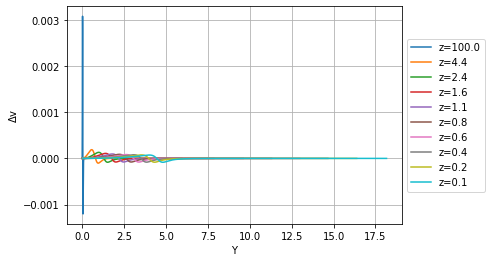

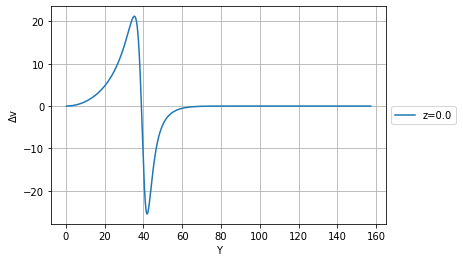

In [39]:
DB = np.zeros( (len(tspan),n+1) )
DV = np.zeros( (len(tspan),n+1) )


for i in range(0,len(tspan)):
    DB[i,:] = np.gradient(BSol[i,:],r)
    DV[i,:] = np.gradient(VSol[i,:],r)


Dvpec = (2.*ChSol/YSol - DB/BSol)*VSol*YSol/BSol**2.+DV*YSol/BSol**2.

#se realiza una grafica de la soluciones Dvpec vs Y para cada paso de tiempo de integracion

plt.figure(1)

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], Dvpec[i,:], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.2])
#axes.set_ylim([0.9,1.1])
plt.xlabel(r'Y')
plt.ylabel(r'$\Delta$v')

axes = plt.gca()


plt.grid(True)

plt.figure(2)

plt.plot(YSol[-1,:]*L, Dvpec[-1,:]*c, label='z={0:1.1f}'.format(z1[-1]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([-0.1,10])
#axes.set_ylim([0.9,1.1])
plt.xlabel(r'Y')
plt.ylabel(r'$\Delta$v')

axes = plt.gca()


plt.grid(True)

In [40]:
z23=np.where(np.logical_and(z1>=22, z1<=24))
t2=np.where(np.logical_and(tspan>=0.8, tspan<=1))
print(z23)
print(t2)
print(z1[10])
print(tspan[33])

(array([ 9, 10]),)
(array([], dtype=int64),)
22.344188114980906
17.59812678456202


In [41]:
v23max = np.amax(VSol[10,:])

print('v23max = ', v23max)
v23max2 = v23max*c

print('v23max en km/s = ', v23max2)

print('L en Mpc = ', L)


v23max =  0.0011857705110775768
v23max en km/s =  355.48505613986293
L en Mpc =  7.862676639758348
